## TRAINING
This notebook has as an objective to use a folder containing the formated .npy files to train a deep learning model that can be used in lieu of an FEA model to any accuracy above random, for a proof of concept that it is possible to do so, such that further research can be done afterward to optimize architecture, hyperparameters and data being fed in.

In [1]:
##  imports

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pathlib
import PREPROCESSING_splitting as split
import matplotlib.pyplot as plt
import torchvision.transforms

splitting functions imported


## WEIGHTS AND BIASES
This section's purpose  is to set up logging for the tests

In [146]:
import wandb

In [147]:
import os
os.getcwd()

'D:\\Ansys Simulations\\Project\\2D\\preprocessing'

In [3]:
#import importlib
#importlib.reload(torch)

In [2]:
## first, create a class to load the files that are to be fed to the neural network, 
## for both the inputs and the outputs. To avoid confusion I'll refer to the inputs to the 
## FEA model as 'bound_conds' (boundary conditions), and the outputs as 'targets', while what 
## is fed into the neural network will be called an "input", and the output of the neural network "prediction"
## this function should probably be transformed into a dataloader later for a larger dataset, 
## but for now we'll keep it like this

def get_dataset(dataset_path, glob_parameter = '*.npy'):
    # concatenates all samples into a list of boundary conditions and a list of targets
    
    # set paths
    bound_cond_path = pathlib.Path(dataset_path, 'input')
    targets_path = pathlib.Path(dataset_path, 'output')  
    
    print(bound_cond_path)
    # check if folder path is correct
    if bound_cond_path.is_dir() and targets_path.is_dir():
        print('path contains \'input\' and \'output\'')
        pass
    else:
        raise Exception (f'Argument dataset_path: {dataset_path} should contain folders ..\input and ..\output. Please check path')
    
    #create iterators for files
    bound_cond_iterator = bound_cond_path.glob(glob_parameter)
    targets_iterator = targets_path.glob(glob_parameter)
    
    #zip them to ensure that they are going through the same samples 
    samples_iterator = zip(bound_cond_iterator, targets_iterator)
    
    boundary_conditions = np.array([])
    targets = np.array([])
    
    for boundary_condition_files, targets_files in samples_iterator:
        if split.get_number(boundary_condition_files.name) == split.get_number(targets_files.name):
            
            boundary_conditions_temp = np.load(boundary_condition_files)
            targets_temp = np.load(targets_files)
            
            #start array if it hasn't been started yet
            if boundary_conditions.size == 0 and targets.size == 0:
                boundary_conditions = boundary_conditions_temp
                targets = targets_temp
            else:
                boundary_conditions = np.concatenate((boundary_conditions, boundary_conditions_temp), axis = 0)
                targets = np.concatenate((targets, targets_temp), axis = 0)
        else:
            raise Exception('the samples in the iterator are not synced')
    
    return torch.from_numpy(boundary_conditions).float(), torch.from_numpy(targets).float()
    

In [3]:
folders_path =  pathlib.Path('D:/Ansys Simulations/Project/2D/data/proof_of_concept_V2/scaled/arrays')
dataset = get_dataset(dataset_path = folders_path)
print(dataset[0].size)
print(dataset[1].shape)

D:\Ansys Simulations\Project\2D\data\proof_of_concept_V2\scaled\arrays\input
path contains 'input' and 'output'
<built-in method size of Tensor object at 0x000002C93F48AA98>
torch.Size([102, 4, 32, 32])


In [4]:
print(dataset[0].size(0))

102


## Create a Dataloader


In [5]:
## first the dataset that is going to be used in the dataloader
class TwoD_Dataset(torch.utils.data.Dataset):
    """Two D displacement dataset."""

    def __init__(self, root_dir, glob_parameter = '*.npy', transform=None):
        """
        Args:
            root_dir (string): Directory with all the arrays.
            glob_parameter (string): string with the correct glob to select files inside of folders
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataset = get_dataset(root_dir, glob_parameter = '*.npy')
        self.transform = transform

    def __len__(self):
        assert (self.dataset[0].size(0) == self.dataset[1].size(0)), 'different input and output sizes'
        return self.dataset[0].size(0)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        bc = self.dataset[0][idx, :, :, :]
        tgt = self.dataset[1][idx, :, :, :]
        
        sample = {'boundary_conditions': bc, 'target': tgt}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
## create dataset
folders_path =  pathlib.Path('D:/Ansys Simulations/Project/2D/data/proof_of_concept_V2/scaled/arrays')
dataset = TwoD_Dataset(folders_path, glob_parameter = '*.npy')

D:\Ansys Simulations\Project\2D\data\proof_of_concept_V2\scaled\arrays\input
path contains 'input' and 'output'


In [316]:
dataset[1]['boundary_conditions'].shape

torch.Size([7, 32, 32])

In [7]:
## create dataloader object
##  transforms needto be applied to dataset step
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4,
                        shuffle=True, num_workers=3)
dataloader

In [318]:
#torch.ones(3)*np.cos(np.random.uniform(low = -np.pi, high = np.pi))

In [61]:
'''print("\n grid test")
x = torch.tensor([1, 2])
y = torch.tensor([4, 5])
grid_x, grid_y = torch.meshgrid(x, y)
print(grid_x)
print(grid_y)'''

resolution = 17

print("\n Create dummy image")
zeroes = torch.zeros(1, 1, resolution, resolution)
im[:, :, :, 2] = 1.
print(im)

angle = torch.tensor([135 * np.pi / 180.])
print(angle/np.pi*180)
## rot matrix

rot_matrix = torch.tensor([[np.cos(angle), np.sin(angle)],
                                [-1.0*np.sin(angle), np.cos(angle)]])

print("\n # Calculate rotation for each target pixel")
x_mid = (im.size(2) + 1) / 2.
print(x_mid)
y_mid = (im.size(3) + 1) / 2.
print(y_mid)
im_rot = torch.zeros_like(im)


print("\n # Use meshgrid for pixel coords")
xv, yv = torch.meshgrid(torch.arange(im.size(2)), torch.arange(im.size(3)))
xv = xv.contiguous()
yv = yv.contiguous()
#print(xv)
#print(yv)
src_ind = torch.cat((
    (xv.float() - x_mid).view(-1, 1),
    (yv.float() - y_mid).view(-1, 1)),
    dim=1
)
print(xv.view(-1))
print(yv.view(-1))
print(src_ind.shape)
print(rot_matrix.t().shape)

#print(src_ind)

print( "\n # Calculate indices using rotation matrix")
src_ind = torch.matmul(src_ind, rot_matrix.t())
src_ind = torch.round(src_ind)

src_ind += torch.tensor([[x_mid, y_mid]])

# Set out of bounds indices to limits
src_ind[src_ind < 0] = 0.
src_ind[:, 0][src_ind[:, 0] >= im.size(2)] = float(im.size(2)) - 1
src_ind[:, 1][src_ind[:, 1] >= im.size(3)] = float(im.size(3)) - 1
 
im_rot2 = torch.zeros_like(im)
src_ind = src_ind.long()
im_rot2[:, :, xv.view(-1), yv.view(-1)] = im[:, :, src_ind[:, 0], src_ind[:, 1]]
im_rot2 = im_rot2.view(1, 1, resolution, resolution)
print(im_rot)
print(im_rot2)


 Create dummy image
tensor([[[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 

In [161]:
## create a vector rotation transform


class DirectionalRotation(object):
    """Rotate a vector with directional coordinates.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size, dimensionality):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        self.dimensionality = dimensionality.lower()

    def __call__(self, sample):
        boundary_condition, target = sample['boundary_conditions'], sample['target']
        # get angle
        "print(boundary_condition.shape)"
        angle = np.random.uniform(low = -np.pi, high = np.pi)
        "print(angle)"
        
        assert self.dimensionality == '2d', '3D NOT IMPLEMENTED YET'
        
        ###############################
        ## boundary conditions
        ###############################
        
        ######
        ###### rotate directional vectors ####
        ######
        boundary_condition_temp = boundary_condition.clone()
        #print(boundary_condition_temp.shape)
        boundary_condition_temp[1:2 , :, :] = boundary_condition[1:2 , :, :]*np.cos(angle) \
                                                - boundary_condition[2:3 , :, :]*np.sin(angle)
        
        boundary_condition_temp[2:3 , :, :] = boundary_condition[1:2 , :, :]*np.sin(angle) \
                                                + boundary_condition[2:3 , :, :]*np.cos(angle)
        
        boundary_condition_temp[4:5 , :, :] = boundary_condition[4:5 , :, :]*np.cos(angle) \
                                                - boundary_condition[5:6 , :, :]*np.sin(angle)
        
        boundary_condition_temp[5:6 , :, :] = boundary_condition[4:5 , :, :]*np.sin(angle) \
                                                + boundary_condition[5:6 , :, :]*np.cos(angle)
        #####
        ##### rotate tensor ####
        #####
        
        # Calculate rotation with inverse rotation matrix
        rot_matrix = torch.tensor([[np.cos(angle), np.sin(angle)],
                                [-1.0*np.sin(angle), np.cos(angle)]]).float()
            
        # Calculate rotation for each target pixel"
        x_mid = (boundary_condition.size(1) + 1) / 2
        y_mid = (boundary_condition.size(2) + 1) / 2

        # Use meshgrid for pixel coords")
        xv, yv = torch.meshgrid(torch.arange(boundary_condition.size(1)), torch.arange(boundary_condition.size(2)))
        xv = xv.contiguous()
        yv = yv.contiguous()
        src_ind = torch.cat((
            (xv.float() - x_mid).view(-1, 1),
            (yv.float() - y_mid).view(-1, 1)),
            dim=1
                )
            
        # Calculate indices using rotation matrix
        src_ind = torch.matmul(src_ind, rot_matrix.t())
        src_ind = torch.round(src_ind)    
        
        # translate to mid
        src_ind += torch.tensor([[x_mid, y_mid]])
        
        # Set out of bounds indices to limits
        src_ind[src_ind < 0] = 0.
        src_ind[:, 0][src_ind[:, 0] >= boundary_condition.size(1)] = float(boundary_condition.size(1)) - 1
        src_ind[:, 1][src_ind[:, 1] >= boundary_condition.size(2)] = float(boundary_condition.size(2)) - 1
        
        src_ind = src_ind.long()
        
        ####################################
        ## targets
        ####################################
        ######
        ###### rotate directional vectors ####
        ######
        target_temp = target.clone()
        target_temp[1:2 , :, :] = target[1:2 , :, :]*np.cos(angle) \
                                                - target[2:3 , :, :]*np.sin(angle)
        
        target_temp[2:3 , :, :] = target[1:2 , :, :]*np.sin(angle) \
                                                + target[2:3 , :, :]*np.cos(angle)

        #####
        ##### rotate tensors ####
        #####
        boundary_conditions_rotated = torch.zeros_like(boundary_condition)
        target_rotated = torch.zeros_like(target)
        target_rotated[:, xv.view(-1), yv.view(-1)] = target_temp[:, src_ind[:, 0], src_ind[:, 1]]
        boundary_conditions_rotated[:, xv.view(-1), yv.view(-1)] = boundary_condition_temp[:, src_ind[:, 0], src_ind[:, 1]]
        """#TEST: tests if the magnitude is still the same after rotation. It should be.
        print(torch.mean(torch.sqrt((target[1:2,:,:]**2 + target[2:3,:,:]**2))))
        print(torch.mean(torch.sqrt((target_temp[1:2,:,:]**2 + target_temp[2:3,:,:]**2))))"""
        
        
        # detach tensors to counter leaf error
        boundary_conditions_rotated = boundary_conditions_rotated.detach()
        boundary_conditions_rotated.requires_grad = True
        target_rotated = target_rotated.detach()
        target_rotated.requires_grad = True
        #print('going')
        

        return {'boundary_conditions': boundary_conditions_rotated, 'target': target_rotated}
    
direc_test = DirectionalRotation(32, dimensionality = '2D')

In [32]:
## try to plot rotated images
#plot ground truth
sample =96
print(len(dataset))
sample_dict = direc_test(dataset[:])

102


In [163]:

## create dataset
folders_path =  pathlib.Path('D:/Ansys Simulations/Project/2D/data/proof_of_concept_V2/scaled/arrays')

## transform the dataset
transformed_dataset = TwoD_Dataset(folders_path, glob_parameter = '*.npy',
                                           transform = DirectionalRotation(32, dimensionality = '2D'))

## create the dataloader
transformed_dataloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=6,
                        shuffle=True)
transformed_dataloader

D:\Ansys Simulations\Project\2D\data\proof_of_concept_V2\scaled\arrays\input
path contains 'input' and 'output'


<class '__main__.TwoD_Dataset'>
1
2
3
(32, 32, 7) (32, 32, 4)
4


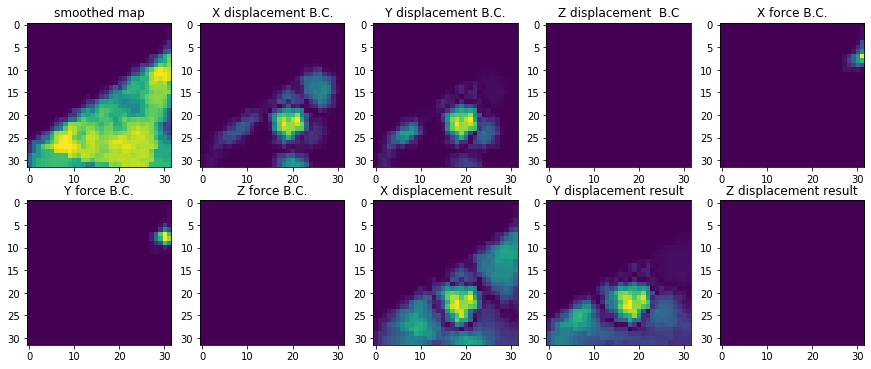

In [245]:
#plot ground truth
sample =80
print(type(transformed_dataset))
sample_transformed = transformed_dataset[sample]
print('1')
sample_bc = np.moveaxis(sample_transformed['boundary_conditions'].data.clone().data.numpy(), 0, 2)
print('2')
sample_target = np.moveaxis(sample_transformed['target'].clone().data.numpy(), 0, 2)
print('3')
print(sample_bc.shape, sample_target.shape)
print('4')
plot_grid_2d(sample_bc, sample_target)

In [58]:
for i_batch, sample_batched in enumerate(transformed_dataloader):
    print(i_batch, sample_batched['boundary_conditions'].size(),
          sample_batched['target'].size())

0 torch.Size([6, 7, 32, 32]) torch.Size([6, 4, 32, 32])
1 torch.Size([6, 7, 32, 32]) torch.Size([6, 4, 32, 32])
2 torch.Size([6, 7, 32, 32]) torch.Size([6, 4, 32, 32])
3 torch.Size([6, 7, 32, 32]) torch.Size([6, 4, 32, 32])
4 torch.Size([6, 7, 32, 32]) torch.Size([6, 4, 32, 32])
5 torch.Size([6, 7, 32, 32]) torch.Size([6, 4, 32, 32])
6 torch.Size([6, 7, 32, 32]) torch.Size([6, 4, 32, 32])
7 torch.Size([6, 7, 32, 32]) torch.Size([6, 4, 32, 32])
8 torch.Size([6, 7, 32, 32]) torch.Size([6, 4, 32, 32])
9 torch.Size([6, 7, 32, 32]) torch.Size([6, 4, 32, 32])
10 torch.Size([6, 7, 32, 32]) torch.Size([6, 4, 32, 32])
11 torch.Size([6, 7, 32, 32]) torch.Size([6, 4, 32, 32])
12 torch.Size([6, 7, 32, 32]) torch.Size([6, 4, 32, 32])
13 torch.Size([6, 7, 32, 32]) torch.Size([6, 4, 32, 32])
14 torch.Size([6, 7, 32, 32]) torch.Size([6, 4, 32, 32])
15 torch.Size([6, 7, 32, 32]) torch.Size([6, 4, 32, 32])
16 torch.Size([6, 7, 32, 32]) torch.Size([6, 4, 32, 32])


## BASE

In [314]:
## define the neural network's general shape

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        ## convolutional layers
        self.conv1 = nn.Conv2d(in_channels = 7, out_channels = 14, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 14, out_channels = 16, kernel_size = 3, padding = 1)
        self.deconv1 = nn.ConvTranspose2d(in_channels = 16, out_channels = 14, kernel_size = 3, padding = 1)
        self.deconv2 = nn.ConvTranspose2d(in_channels = 14, out_channels = 10, kernel_size = 3, padding = 1)
        self.deconv3 = nn.ConvTranspose2d(in_channels = 10, out_channels = 7, kernel_size = 3, padding = 1)
        self.deconv4 = nn.ConvTranspose2d(in_channels = 7, out_channels = 3, kernel_size = 3, padding = 1)
        
        ## activation
        self.hardtanh = nn.Hardtanh()
        
        
        ##possible for later: MultiheadAttention
        self.multihead_attn_middle = SelfAttention(in_dim = 16, activation = None)
        
        
        ### spatial transform network for spatial invariance ###
        self.localization = nn.Sequential(
            nn.Conv2d(7, 8, kernel_size=2,  padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=2, padding = 1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 8 * 8, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        
    def stn(self, x):
        xs = self.localization(x)
        #print(xs.shape)
        xs = xs.view(-1, 10 * 8 * 8)
        theta = self.fc_loc(xs)
        #print(theta.shape)
        theta = theta.view(-1, 2, 3)
        #print(theta.shape)
        #print(x.size())
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x
    
    def forward(self, boundary_conditions):
        
        # spatially transform the input
        x = self.stn(boundary_conditions)
        
        
        #print(boundary_conditions.shape)
        x = self.conv1(x)
        x = self.hardtanh(x)
        #print(x.shape)
        x = self.conv2(x)
        x = self.multihead_attn_middle(x)
        x = self.hardtanh(x)
        #print(x.shape)
        x = self.deconv1(x)
        x = self.hardtanh(x)
       #print(x.shape)
        x = self.deconv2(x)
        x = self.hardtanh(x)
        #print(x.shape)
        x = self.deconv3(x)
        x = self.hardtanh(x)
       # print(x.shape)
        x = self.deconv4(x)
        x = self.hardtanh(x)
        #print(x.shape)
        return x
    
net = ConvNet().cuda().float()

## test to see if getting the correct size
net.forward(dataset[0]['boundary_conditions'].unsqueeze(0).cuda())

tensor([[[[-0.1604, -0.1200, -0.1191,  ..., -0.1121, -0.0894, -0.0821],
          [-0.1680, -0.1367, -0.1327,  ..., -0.1192, -0.0813, -0.0760],
          [-0.1459, -0.1304, -0.1323,  ..., -0.1246, -0.0910, -0.0852],
          ...,
          [-0.1285, -0.1168, -0.1217,  ..., -0.1435, -0.1108, -0.1088],
          [-0.1267, -0.1050, -0.1079,  ..., -0.1297, -0.1123, -0.1049],
          [-0.1252, -0.1474, -0.1495,  ..., -0.1702, -0.1704, -0.1370]],

         [[-0.0525, -0.0594, -0.0610,  ..., -0.0687, -0.0631, -0.0911],
          [-0.0576, -0.1125, -0.1138,  ..., -0.1224, -0.1124, -0.1422],
          [-0.0414, -0.0825, -0.0837,  ..., -0.0952, -0.0908, -0.1313],
          ...,
          [-0.0489, -0.0838, -0.0863,  ..., -0.1021, -0.0859, -0.1239],
          [-0.0554, -0.0921, -0.0960,  ..., -0.1045, -0.0897, -0.1095],
          [-0.0519, -0.0962, -0.0871,  ..., -0.0992, -0.0900, -0.0966]],

         [[-0.0485, -0.0333, -0.0418,  ..., -0.0408, -0.0076,  0.0388],
          [-0.0641, -0.0672, -

In [315]:
## define criterion
criterion = nn.MSELoss().cuda()
learn_rate = 0.0001
optimizer = torch.optim.Adam(params = net.parameters(), lr=learn_rate, betas=(0.9, 0.999))

In [316]:
## create dataset
folders_path =  pathlib.Path('D:/Ansys Simulations/Project/2D/data/proof_of_concept_V2/scaled/arrays')

## transform the dataset
transformed_dataset = TwoD_Dataset(folders_path, glob_parameter = '*.npy',
                                           transform = DirectionalRotation(32, dimensionality = '2D'))
## train dataset 
print(len(transformed_dataset))
train_percentage = 0.9
train_length = int(len(transformed_dataset)*train_percentage)
test_length = len(transformed_dataset) - train_length
train_dataset, val_dataset = torch.utils.data.random_split(transformed_dataset, (train_length, test_length))
print(len(train_dataset), len(val_dataset))


batch_size = 6
## create the dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size,
                        shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size,
                        shuffle=True)

D:\Ansys Simulations\Project\2D\data\proof_of_concept_V2\scaled\arrays\input
path contains 'input' and 'output'
102
91 11


In [317]:
## setup logging
epochs = 500
wandb.init(config={"epochs": epochs, "batch_size": batch_size,'learning_rate': learn_rate, 'architecture':'stn_with_attention_architecture_kernel2', 'database': 'v3'})

wandb: Wandb version 0.9.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/walther/Project/runs/12s2fs91

In [318]:
%%wandb


## define a general training loop
losses = np.array([0,0,0])
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0

    #print(type(boundary_conditions))
    #net = net.cuda()
    for i, sample_batch in enumerate(train_dataloader):
        #print(sample_batch["boundary_conditions"].size(), sample_batch["target"].size())
        bc = sample_batch["boundary_conditions"].cuda()
        tgt = sample_batch["target"][:, 1:4, :,  :].cuda()
        #material_matrix = bc[i, 0, :, :].unsqueeze(0).repeat([1,3,1,1])
        #print(i, bc.shape, tgt.shape)

        # get the inputs; data is a list of [boundary_conditions, targets]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        prediction = net(bc)
        
        loss_x = criterion(prediction[:, 0, :, :], tgt[:, 0, :, :])#/torch.sum(material_matrix)
        loss_y = criterion(prediction[:, 1, :, :], tgt[:, 1, :, :])
        loss = loss_x + loss_y
        #print(loss)
        loss.backward()
        optimizer.step()
        
        
        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 10 mini-batches
            running_val_loss = 0.0
            with torch.no_grad():
                for ii, sample_val_batch in enumerate(val_dataloader):
                    bc_val = sample_val_batch["boundary_conditions"].cuda()
                    tgt_val = sample_val_batch["target"][:, 1:4, :,  :].cuda()
                    
                    prediction_val = net(bc_val)
                    
                    loss_x_val = criterion(prediction_val[:, 0, :, :], tgt_val[:, 0, :, :])#/torch.sum(material_matrix)
                    loss_y_val = criterion(prediction_val[:, 1, :, :], tgt_val[:, 1, :, :])
                    val_loss = loss_x_val + loss_y_val
                    
                    running_val_loss+=val_loss.item()
                
            print(f'{epoch + 1} {i + 1} {running_loss} {running_val_loss/10}')
            wandb.log({"loss": running_loss})
            wandb.log({"val_loss": running_val_loss})
            losses = np.vstack((losses, [epoch, running_loss, running_val_loss]))
            #print(losses)
            running_loss = 0.0
            

print('Finished Training')

1 1 0.02940939925611019 0.004943076334893703


wandb: Wandb version 0.9.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


2 1 0.007430833764374256 0.0013849308714270591
3 1 0.0038166362792253494 0.000713915191590786
4 1 0.0031370227225124836 0.0006142296362668276
5 1 0.031136298552155495 0.0005807065637782217
6 1 0.0022487237583845854 0.0005157147999852896
7 1 0.002456066431477666 0.00041524639818817376
8 1 0.005568023305386305 0.0004423773381859064
9 1 0.0026848898269236088 0.00041518108919262885
10 1 0.0021736235357820988 0.00041341208852827547
11 1 0.0024944159667938948 0.00038543506525456905
12 1 0.003398967906832695 0.0004260390531271696
13 1 0.0016932848375290632 0.000377675227355212
14 1 0.0021375268697738647 0.0003811416449025273
15 1 0.0037070426624268293 0.0004077711375430226
16 1 0.002062608255073428 0.0003696630476042628
17 1 0.0014394812751561403 0.00039428664604201913
18 1 0.002011821838095784 0.00040675208438187835
19 1 0.009458068758249283 0.00039795227348804474
20 1 0.025965087115764618 0.0003878885880112648
21 1 0.0015101401368156075 0.00039494374068453907
22 1 0.0028954842127859592 0.00

169 1 0.001046505058184266 0.0002898395527154207
170 1 0.0018391136545687914 0.0002757202717475593
171 1 0.0015851525822654366 0.00026881545782089236
172 1 0.0011601956794038415 0.0002590770600363612
173 1 0.0010147520806640387 0.0002573804697021842
174 1 0.001595364767126739 0.0002760986564680934
175 1 0.001486063003540039 0.00025986084947362544
176 1 0.0015068183420225978 0.00025607189163565634
177 1 0.0020659351721405983 0.000264122593216598
178 1 0.008496750146150589 0.000251636968459934
179 1 0.0009292780887335539 0.00025629609590396287
180 1 0.023115430027246475 0.0002541053225286305
181 1 0.0011007790453732014 0.000252139987424016
182 1 0.0013137215282768011 0.0002467214595526457
183 1 0.0014824287500232458 0.0002606706111691892
184 1 0.03073207102715969 0.00026350130792707205
185 1 0.0024240962229669094 0.00024150130338966845
186 1 0.0016324521275237203 0.00025037330342456696
187 1 0.001609966391697526 0.0002457584661897272
188 1 0.0011031129397451878 0.0002816665801219642
189 

333 1 0.0015442327130585909 0.00019089426496066153
334 1 0.0006730778841301799 0.00017592074582353234
335 1 0.0008753121946938336 0.00015153733547776938
336 1 0.0008952051284722984 0.0001621674105990678
337 1 0.0017579752020537853 0.0001412542420439422
338 1 0.0011296492302790284 0.0001720903441309929
339 1 0.0016516880132257938 0.0001506237080320716
340 1 0.001276531140320003 0.0001561868586577475
341 1 0.0021827463060617447 0.00014983772416599095
342 1 0.0017120125703513622 0.00014944217982701958
343 1 0.008603375405073166 0.00018087427015416323
344 1 0.007208489812910557 0.00016639386303722857
345 1 0.0011475947685539722 0.0001586532627698034
346 1 0.001272792462259531 0.00015665350947529076
347 1 0.001291388412937522 0.0001468219212256372
348 1 0.001092840451747179 0.0001520190737210214
349 1 0.0006909038638696074 0.0001542551501188427
350 1 0.0011281119659543037 0.0001534809242002666
351 1 0.002332620322704315 0.0001545043312944472
352 1 0.0017952843336388469 0.0001608465914614498

496 1 0.0016623856499791145 0.00014697694568894805
497 1 0.002248564502224326 0.0001383610477205366
498 1 0.02997458539903164 0.0001602306845597923
499 1 0.002388986758887768 0.00015713671164121478
500 1 0.0008925918955355883 0.00015600030310451983
Finished Training


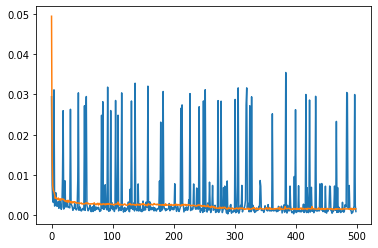

In [319]:
## attempt to plot losses over time
plt.plot(losses[1:,0], losses[1:,1:])

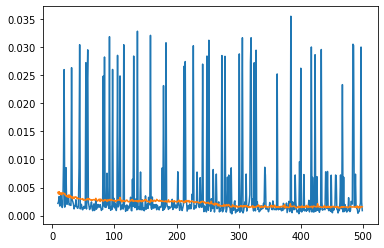

In [320]:
## attempt to plot losses over time to sho where the model started overfitting on the data
plt.plot(losses[10:,0], losses[10:,1:])

Therefore, it can be seen that the network learns some of the relationships in the dataset, and is able to overfit it after a while. After adding a dataloader, the training improved tremendously because of the data augmentation

In [56]:
%matplotlib inline 
#f = plt.figure()


#plt.imshow(concat_input[:,:,0])
def plot_grid_2d(concat_input, concat_output):
    
    f, axarr = plt.subplots(2,5, figsize = (15,6)) 
    
    axarr[0,0].imshow(np.abs(concat_input[:,:,0]))
    axarr[0,0].set(title='smoothed map')

    axarr[0,1].imshow(np.abs(concat_input[:,:,1]))
    axarr[0,1].set(title='X displacement B.C.')

    axarr[0,2].imshow(np.abs(concat_input[:,:,2]))
    axarr[0,2].set(title='Y displacement B.C.')

    axarr[0,3].imshow(np.abs(concat_input[:,:,3]))
    axarr[0,3].set(title='Z displacement  B.C')

    axarr[0,4].imshow(np.abs(concat_input[:,:,4]))
    axarr[0,4].set(title='X force B.C.')

    axarr[1,0].imshow(np.abs(concat_input[:,:,5]))
    axarr[1,0].set(title='Y force B.C.')

    axarr[1,1].imshow(np.abs(concat_input[:,:,6]))
    axarr[1,1].set(title='Z force B.C.')

    axarr[1,2].imshow(np.abs(concat_output[:,:,1]))
    axarr[1,2].set(title='X displacement result')

    axarr[1,3].imshow(np.abs(concat_output[:,:,2]))
    axarr[1,3].set(title='Y displacement result')

    axarr[1,4].imshow(np.abs(concat_output[:,:,3]))
    axarr[1,4].set(title='Z displacement result')

    plt.show()

torch.Size([1, 7, 32, 32])
torch.Size([1, 3, 32, 32])
(1, 4, 32, 32)
(1, 32, 32, 4)


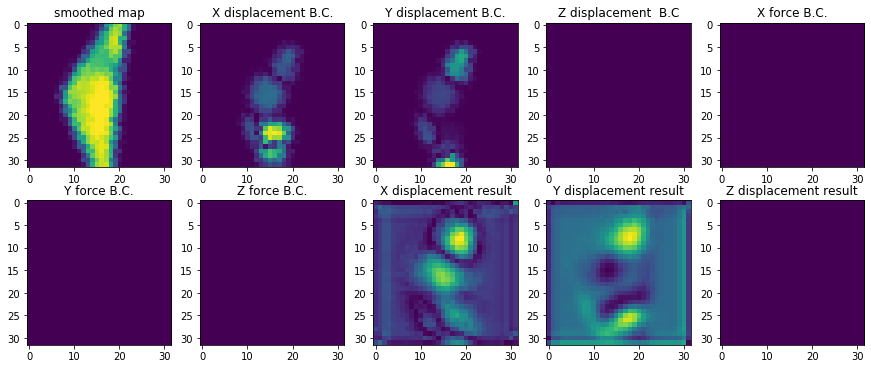

In [339]:
sample = 62
sample_transformed = transformed_dataset[sample]
sample_bc = np.moveaxis(sample_transformed['boundary_conditions'].data.clone().data.numpy(), 0, 2)
## plot one of the results after passing the convolutional network through it once
print(sample_transformed['boundary_conditions'].data.clone().unsqueeze(0).shape)
sample_prediction = net.cpu().forward(sample_transformed['boundary_conditions'].data.clone().unsqueeze(0))
print(sample_prediction.shape)
sample_prediction = F.pad(sample_prediction, (0,0,0,0,0,1)).detach().numpy()
print(sample_prediction.shape)
sample_prediction = np.moveaxis(sample_prediction, 1, 3)
print(sample_prediction.shape)


#print(sample_prediction.shape, dataset[0][27:28,:,10,22], sample_prediction[:,:,10,22])
plot_grid_2d(sample_bc, sample_prediction[0,:,:,:])

So one of the conclusions is that the convolutional network was  able to succesfully learn a model that can be applied to a space to generate a result  that correlates to the target. Even with a very small number of samples, the network was able to learn some basic principles about the geometry of the sample and of the relationships between boundary conditions and targets. With a spatial transform, there was a breakthrough point where it actually learned much more. This is the way to go.

In [53]:
## get loss of the results
with torch.no_grad():
    print(dataset[1][sample, 1:4, :, :].unsqueeze(0).shape)
    print(net.forward(dataset[0][sample:sample+1,:,:,:]).shape)
    loss_1_it = criterion(dataset[1][sample, 1:4, :, :].unsqueeze(0), net.forward(dataset[0][sample:sample+1,:,:,:]))
    print(f'{loss_1_it: .9f}')

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
 0.000156545


In [32]:
## create a generator to evaluate how loss progresses with multiple applications of the network
def convolute_iteration(conditions, netwrk, repeat = True):
    with torch.no_grad():
        pred = netwrk(conditions) #torch.Size([1, 3, 32, 32])
        new_condition = conditions.clone()
        new_condition[:, 1:4, :, :] = pred
        i=0
        while repeat:
            i +=1
            print(i)
            pred = netwrk(new_condition)
            new_condition = conditions.clone()
            new_condition[:, 1:4, :, :] = pred
            
            yield pred

In [118]:
## create iterator intance for loss plot
predicts = convolute_iteration(dataset[0][sample:sample+1,:,:,:], net)
loss_iterator = []

95
 0.116603315


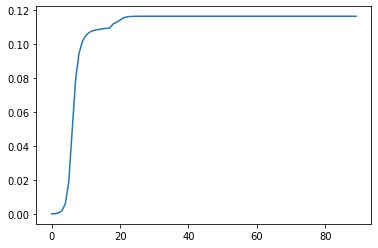

In [213]:
with torch.no_grad():
    
    loss_2_it = criterion(dataset[1][sample, 1:4, :, :].unsqueeze(0), next(predicts))
    loss_iterator.append(loss_2_it)
    print(f'{loss_2_it: .9f}')
    plt.plot(loss_iterator)

What has been shown with this is that subsequent applications of this model don't increase its accuracy, however it does converge to a certain value. The fact that there is convergence is grounds for exploring whether this convergence can be used as a feature of the model itself.

In [215]:
## create iterator intance for prediction plot
predicts = convolute_iteration(dataset[0][sample:sample+1,:,:,:], net)


2
torch.Size([1, 3, 32, 32])
(1, 4, 32, 32)
(1, 32, 32, 4)


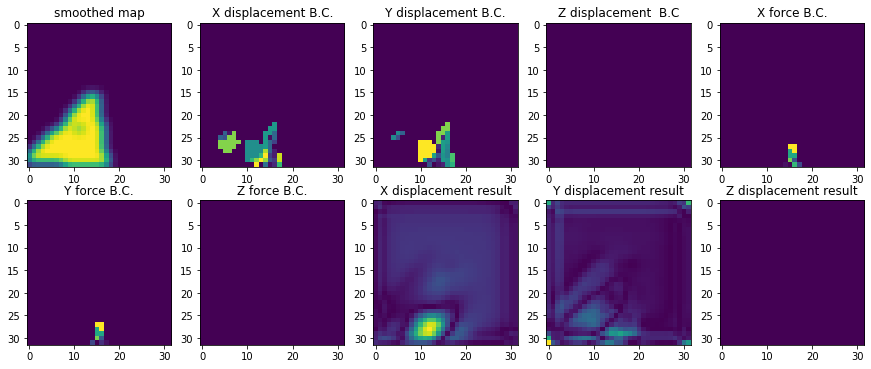

In [217]:
sample_prediction = next(predicts)
print(sample_prediction.shape)
sample_prediction = F.pad(sample_prediction, (0,0,0,0,0,1)).detach().numpy()
print(sample_prediction.shape)
sample_prediction = np.moveaxis(sample_prediction, 1, 3)
print(sample_prediction.shape)


#print(sample_prediction.shape, dataset[0][27:28,:,10,22], sample_prediction[:,:,10,22])
plot_grid_2d(sample_bc, sample_prediction[0,:,:,:])

Now I want to explore a lot of things and their impact on the model's predictions:

- leaning rates
- different conv deconv architectures
- pre-trained models (if models trained on images help with accuracy in this case, then it is possible to use models trained in other types of object for the 3d version)
- attention
- different losses
- increase amount of model forward feeds before doing gradient descent to try to get the model to converge closer to the target value if applied several times
- Other activation strategies

## ENCODER DECODER

In [19]:
##update loging
wandb.init(config={"epochs": 30, "batch_size": 90,'learning_rate': 0.0005, 'architecture':'encoder_decoder_architecture'})

W&B Run: https://app.wandb.ai/walther/Project/runs/f9a3hvrd

In [20]:

## First, see the result of a conv-deconv architecture with exactly the same parameters but that condenses
## the inputs into a feature array first
## define the neural network's general shape

class Encode_decode_Net(nn.Module):
    def __init__(self):
        super(Encode_decode_Net, self).__init__()
        
        ## convolutional layers
        self.conv1 = nn.Conv2d(in_channels = 7, out_channels = 14, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 14, out_channels = 16, kernel_size = 3, padding = 1)
        self.deconv1 = nn.ConvTranspose2d(in_channels = 16, out_channels = 14, kernel_size = 3, padding = 1)
        self.deconv2 = nn.ConvTranspose2d(in_channels = 14, out_channels = 10, kernel_size = 2,stride = 2, padding = 0)
        self.deconv3 = nn.ConvTranspose2d(in_channels = 10, out_channels = 7, kernel_size = 2, stride = 2, padding = 0)
        self.deconv4 = nn.ConvTranspose2d(in_channels = 7, out_channels = 3, kernel_size = 3, padding = 1)
        
        ## activation
        self.hardtanh = nn.Hardtanh()
        self.tanh = nn.Tanh()
        self.prelu = nn.PReLU()
        self.leaky_relu = nn.LeakyReLU()
        
        ## Pooling
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        
    def forward(self, boundary_conditions):
        '''
        torch.Size([1, 7, 32, 32])
        torch.Size([1, 14, 16, 16])
        torch.Size([1, 16, 8, 8])
        torch.Size([1, 14, 8, 8])
        torch.Size([1, 10, 16, 16])
        torch.Size([1, 7, 32, 32])
        torch.Size([1, 3, 32, 32])
        '''
        
        #print(boundary_conditions.shape)
        x = self.conv1(boundary_conditions)
        x = self.maxpool(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv1(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv2(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv3(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv4(x)
        x = self.tanh(x)
        #print(x.shape)
        return x
    
        
net = Encode_decode_Net().cuda().float()

## test to see if getting the correct size
net.forward(dataset[0][0:1,:,:,:].cuda());

In [21]:
## define criterion
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(params = net.parameters(), lr=0.0005, betas=(0.9, 0.999))

In [22]:
%%wandb 
## logging cell magic
##
wandb.watch(net)



## define a general training loop
losses = np.array([0,0,0])
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    boundary_conditions, targets = dataset[0][:90,:,:,:].cuda(), dataset[1][:90,:,:,:].cuda()
    #print(type(boundary_conditions))
    for i, bc in enumerate(boundary_conditions):
        tgt = targets[i, 1:4, :, :].unsqueeze(0)
        bc = bc.unsqueeze(0).cuda()
        #print(i, bc.shape, tgt.shape)

        # get the inputs; data is a list of [boundary_conditions, targets]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        prediction = net(bc)
        loss = criterion(prediction, tgt)
        #print(loss)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 10 mini-batches
            running_val_loss = 0.0
            with torch.no_grad():
                boundary_conditions_val, targets_val = dataset[0][90:,:,:,:].cuda(), dataset[1][90:,:,:,:].cuda()
                for ii, bc_val in enumerate(boundary_conditions_val):
                    tgt_val = targets_val[i, 1:4, :, :].unsqueeze(0)
                    bc_val = bc_val.unsqueeze(0)
                    prediction_val = net(bc_val)
                    val_loss = criterion(prediction_val, tgt_val)
                    running_val_loss+=val_loss.item()
                
            print(f'{epoch + 1} {i + 1} {running_loss} {running_val_loss/10}')
            losses = np.vstack((losses, [epoch, running_loss, running_val_loss]))
            wandb.log({"loss": running_loss})
            wandb.log({"val_loss": running_val_loss})
            #print(losses)
            running_loss = 0.0
            

print('Finished Training')

1 1 0.00802171416580677 0.009894485864788295
2 1 0.0003933005500584841 0.0005084899457870051
3 1 0.0003657788038253784 0.00047555426717735825
4 1 0.0003500608145259321 0.0004607861250406131
5 1 0.0003374926163814962 0.00044893036829307675
6 1 0.00032674818066880107 0.00043866110208909956
7 1 0.00031626809504814446 0.00042771732260007413
8 1 0.00030703545780852437 0.0004170465806964785
9 1 0.00028912126435898244 0.00039456723025068643
10 1 0.0002805293188430369 0.0004143378551816568
11 1 0.0002716532617341727 0.0004578035368467681
12 1 0.00026743856142275035 0.0004761294461786747
13 1 0.00026591529604047537 0.0004862652334850281
14 1 0.00026553342468105257 0.0004941005012369714
15 1 0.0002665093925315887 0.0004975401796400547
16 1 0.00026401245850138366 0.0004975621734047309
17 1 0.0002631078823469579 0.0005001711295335553
18 1 0.00026175062521360815 0.0004987697931937874
19 1 0.00026118516689166427 0.0004956273915013298
20 1 0.00026034825714305043 0.0004962697945302353
21 1 0.000259239

So this network achieved lower validation losses, but stayed at a higher training loss. Further, prelu showed very similar behaviour to using hardtanh. 

torch.Size([1, 3, 32, 32])
(1, 4, 32, 32)
(1, 32, 32, 4)


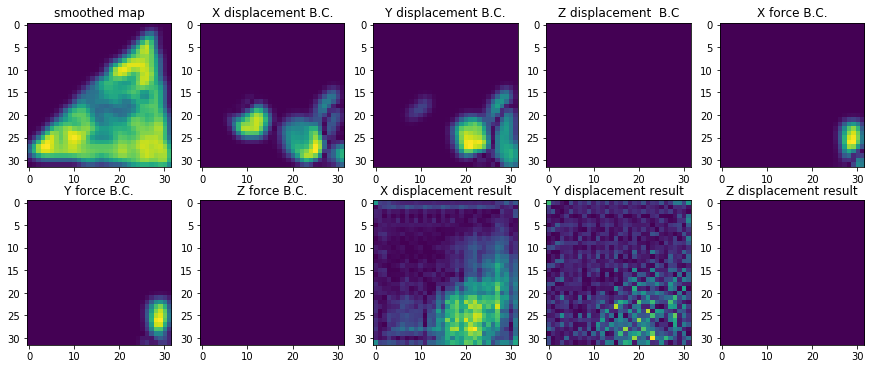

In [23]:
## plot one of the results after passing the convolutional network through it once
sample_prediction = net.cpu().forward(dataset[0][sample:sample+1,:,:,:])
print(sample_prediction.shape)
sample_prediction = F.pad(sample_prediction, (0,0,0,0,0,1)).detach().numpy()
print(sample_prediction.shape)
sample_prediction = np.moveaxis(sample_prediction, 1, 3)
print(sample_prediction.shape)


#print(sample_prediction.shape, dataset[0][27:28,:,10,22], sample_prediction[:,:,10,22])
plot_grid_2d(sample_bc, sample_prediction[0,:,:,:])

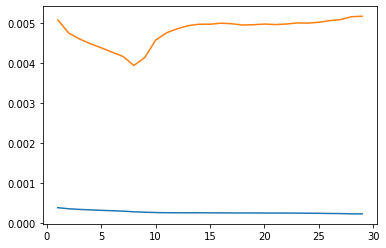

In [24]:
## plot losses over time
plt.plot(losses[2:,0], losses[2:,1:])

## MULTIHEAD ATTENTION

In [25]:
##update loging
wandb.init(config={"epochs": 20, "batch_size": 90,'learning_rate': 0.0002,"amsgrad": True, 'architecture':'attention_architecture_4'})

W&B Run: https://app.wandb.ai/walther/Project/runs/1aaqw1bl

In [24]:
## define attention class

class SelfAttention(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation):
        super(SelfAttention,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//3 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//3 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out

In [28]:
class AttentionNet(nn.Module):
    def __init__(self):
        super(AttentionNet, self).__init__()
        
        ## convolutional layers
        self.conv1 = nn.Conv2d(in_channels = 7, out_channels = 14, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 14, out_channels = 32, kernel_size = 3, padding = 1)
        self.deconv1 = nn.ConvTranspose2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.deconv2 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1)
        self.deconv3 = nn.ConvTranspose2d(in_channels = 32, out_channels = 7, kernel_size = 3, padding = 1)
        self.deconv4 = nn.ConvTranspose2d(in_channels = 7, out_channels = 3, kernel_size = 3, padding = 1)
        
        ## activation
        self.hardtanh = nn.Hardtanh()
        
        ## activation
        self.hardtanh = nn.Hardtanh()
        self.tanh = nn.Tanh()
        self.prelu = nn.PReLU()
        self.leaky_relu = nn.LeakyReLU()
        
        ##possible for later: MultiheadAttention
        self.multihead_attn_in = SelfAttention(in_dim = 14, activation = None)
        self.multihead_attn_out = SelfAttention(in_dim = 3, activation = None)
        self.multihead_attn_middle = SelfAttention(in_dim = 64, activation = None)
    def forward(self, boundary_conditions):
        #print(boundary_conditions.shape)
        x = self.conv1(boundary_conditions)
        x = self.prelu(x)
        x = self.multihead_attn_in(x)
        #print(x.shape)
        x = self.conv2(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv1(x)
        x = self.multihead_attn_middle(x)
        x = self.prelu(x)
       #print(x.shape)
        x = self.deconv2(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv3(x) 
        x = self.prelu(x)
       # print(x.shape)
        x = self.deconv4(x)
        x= self.multihead_attn_out(x)
        x = self.tanh(x)
        #print(x.shape)
        '''
        #print(boundary_conditions.shape)
        x = self.conv1(boundary_conditions)
        #x = self.maxpool(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.conv2(x)
        #x = self.maxpool(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv1(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv2(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv3(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv4(x)
        x = self.tanh(x)
        #print(x.shape)
        '''
        return x
    
net = AttentionNet().cuda().float()

## test to see if getting the correct size
net.forward(dataset[0][0:1,:,:,:].cuda())

tensor([[[[-0.0690, -0.0772, -0.0768,  ..., -0.0767, -0.0840, -0.0722],
          [-0.0702, -0.0780, -0.0769,  ..., -0.0748, -0.0834, -0.0860],
          [-0.0737, -0.0773, -0.0746,  ..., -0.0722, -0.0819, -0.0829],
          ...,
          [-0.0742, -0.0751, -0.0727,  ..., -0.0700, -0.0820, -0.0806],
          [-0.0689, -0.0673, -0.0596,  ..., -0.0590, -0.0705, -0.0718],
          [-0.0614, -0.0442, -0.0367,  ..., -0.0369, -0.0449, -0.0484]],

         [[ 0.2227,  0.2241,  0.2279,  ...,  0.2308,  0.2238,  0.2044],
          [ 0.2156,  0.2178,  0.2296,  ...,  0.2307,  0.2229,  0.1973],
          [ 0.2176,  0.2208,  0.2312,  ...,  0.2292,  0.2201,  0.1937],
          ...,
          [ 0.2226,  0.2260,  0.2339,  ...,  0.2331,  0.2214,  0.1928],
          [ 0.2251,  0.2279,  0.2307,  ...,  0.2282,  0.2190,  0.1857],
          [ 0.2078,  0.1987,  0.2015,  ...,  0.1993,  0.1916,  0.1678]],

         [[ 0.0675,  0.0665,  0.0693,  ...,  0.0724,  0.0750,  0.0932],
          [ 0.0730,  0.0723,  

In [29]:
## define criterion
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(params = net.parameters(), lr=0.0005, betas=(0.9, 0.999), amsgrad = True)

In [30]:
%%wandb 
## logging cell magic
##
wandb.watch(net)



## define a general training loop
losses = np.array([0,0,0])
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    boundary_conditions, targets = dataset[0][:90,:,:,:].cuda(), dataset[1][:90,:,:,:].cuda()
    #print(type(boundary_conditions))
    for i, bc in enumerate(boundary_conditions):
        tgt = targets[i, 1:4, :, :].unsqueeze(0)
        bc = bc.unsqueeze(0).cuda()
        #print(i, bc.shape, tgt.shape)

        # get the inputs; data is a list of [boundary_conditions, targets]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        prediction = net(bc)
        loss = criterion(prediction, tgt)
        #print(loss)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 10 mini-batches
            running_val_loss = 0.0
            with torch.no_grad():
                boundary_conditions_val, targets_val = dataset[0][90:,:,:,:].cuda(), dataset[1][90:,:,:,:].cuda()
                for ii, bc_val in enumerate(boundary_conditions_val):
                    tgt_val = targets_val[i, 1:4, :, :].unsqueeze(0)
                    bc_val = bc_val.unsqueeze(0)
                    prediction_val = net(bc_val)
                    val_loss = criterion(prediction_val, tgt_val)
                    running_val_loss+=val_loss.item()
                
            print(f'{epoch + 1} {i + 1} {running_loss} {running_val_loss/10}')
            losses = np.vstack((losses, [epoch, running_loss, running_val_loss]))
            wandb.log({"loss": running_loss})
            wandb.log({"val_loss": running_val_loss})
            #print(losses)
            running_loss = 0.0
            

print('Finished Training')

1 1 0.02429846301674843 0.02540668398141861
2 1 0.0007163311238400638 0.0008403800777159632
3 1 0.0005203139153309166 0.0005973215826088563
4 1 0.00042779018986038864 0.0005189420480746776
5 1 0.0003548358508851379 0.000480679000611417
6 1 0.0003170428390149027 0.0004949746100464836
7 1 0.00029204992461018264 0.00048785046965349466
8 1 0.00027370822499506176 0.000481858232524246
9 1 0.00026042325771413743 0.0004781895346241072
10 1 0.0002516050008125603 0.0004775788198458031
11 1 0.00024542486062273383 0.00047971723543014375
12 1 0.00024079994182102382 0.00048134978278540074
13 1 0.0002369487629039213 0.00048341818619519473
14 1 0.0002339739876333624 0.00048346761614084246
15 1 0.0002316312602488324 0.00048074031219584866
16 1 0.00022947111574467272 0.00047883272636681793
17 1 0.00022678895038552582 0.00047854370495770127
18 1 0.00022415953571908176 0.0004780370160005987
19 1 0.00022129810531623662 0.00047551620227750393
20 1 0.0002161703014280647 0.00047691580548416825
Finished Traini

So the errors were lower, and it trained and started overfitting extremely quick with a starting attention layer and lr of 0.0005. Looking at the image below, it also learned very well how to identify where the element is. Using attention is definitely a step-up from other strategies.

torch.Size([1, 3, 32, 32])
(1, 4, 32, 32)
(1, 32, 32, 4)


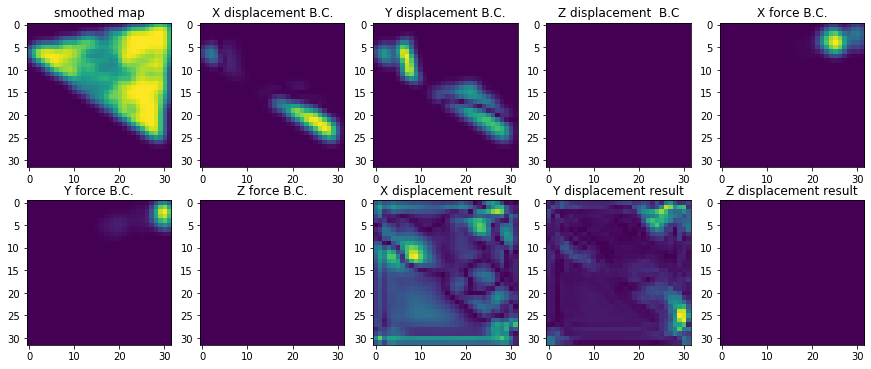

In [47]:
sample = 3
sample_bc = np.moveaxis(dataset[0][sample,:,:,:].numpy(), 0, 2)
## plot one of the results after passing the convolutional network through it once
sample_prediction = net.cpu().forward(dataset[0][sample:sample+1,:,:,:])
print(sample_prediction.shape)
sample_prediction = F.pad(sample_prediction, (0,0,0,0,0,1)).detach().numpy()
print(sample_prediction.shape)
sample_prediction = np.moveaxis(sample_prediction, 1, 3)
print(sample_prediction.shape)


#print(sample_prediction.shape, dataset[0][27:28,:,10,22], sample_prediction[:,:,10,22])
plot_grid_2d(sample_bc, sample_prediction[0,:,:,:])

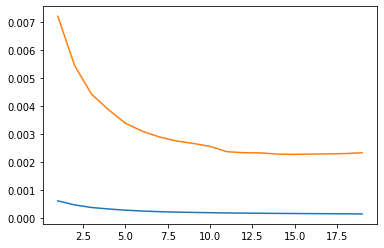

In [101]:
## plot losses over time
plt.plot(losses[2:,0], losses[2:,1:])

## VGG 16
For this section I'll attempt to use a pre-trained architecture to see if that has any effect on the results

In [32]:
##update loging
wandb.init(config={"epochs": 30,'trainable': False, "batch_size": 90,'learning_rate': 0.0005,"amsgrad": False, 'architecture':'vgg16_attention_material_architecture_4'})

W&B Run: https://app.wandb.ai/walther/Project/runs/13yytave

In [33]:
import torchvision.models as models

In [34]:
vgg16 = models.vgg16(pretrained=True)

In [35]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [36]:
## get convolutional portion of model
net = vgg16.features.cuda()

## set it to untrainable
for i, layer in enumerate(net.parameters()):
     layer.requires_grad = False
        
## change first layer to the correct feature size
net[0] = nn.Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# append last layer of correct feature size and correct activation function
net = nn.Sequential(*net, (nn.Conv2d(512, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))))
net = nn.Sequential(*net, nn.Tanh())
net = nn.Sequential(*net[:1],SelfAttention(in_dim = 64, activation = None), *net[1:] )

# send model to gpu
net = net.cuda()

# remove the max pool layers
layer_list = []
for layer in net:
    if not(type(layer) == torch.nn.modules.pooling.MaxPool2d):
        layer_list.append(layer)


# create a model without the maxpool layers
net = nn. Sequential(*layer_list)



net

Sequential(
  (0): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): SelfAttention(
    (query_conv): Conv2d(64, 21, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(64, 21, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU(inplace=True)
  (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU(inplace=True)
  (15): Conv2d(256, 512

In [37]:
for i, layer in enumerate(net.parameters()):
     print(i, layer.requires_grad)

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 True
34 True


In [38]:
## set to only train the added parameters
for i, layer in enumerate(net.parameters()):
    if not( i in [0, 1, 34,33,32]):
        layer.requires_grad = False
    else:
        layer.requires_grad = True
    #print(i, layer.requires_grad)

In [39]:
net.forward(dataset[0][0:1,:,:,:].cuda()).shape

torch.Size([1, 3, 32, 32])

In [40]:
## define criterion
criterion = nn.MSELoss(reduction = 'none').cuda()
optimizer = torch.optim.Adam(params = net.parameters(), lr=0.0005, betas=(0.9, 0.999), amsgrad = False)

In [41]:
%%wandb 
## logging cell magic
##
wandb.watch(net)



## define a general training loop
losses = np.array([0,0,0])
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    boundary_conditions, targets = dataset[0][:90,:,:,:].cuda(), dataset[1][:90,:,:,:].cuda()
    #print(type(boundary_conditions))
    for i, bc in enumerate(boundary_conditions):
        tgt = targets[i, 1:4, :, :].unsqueeze(0)
        material_matrix = boundary_conditions[i, 0, :, :].unsqueeze(0).repeat([1,3,1,1])
        ones = torch.ones_like(material_matrix).cuda()
        #print(ones.shape)
        bc = bc.unsqueeze(0).cuda()
        #print(i, bc.shape, tgt.shape)

        # get the inputs; data is a list of [boundary_conditions, targets]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        prediction = net(bc)
        
        loss = criterion(prediction, tgt)*((material_matrix)+ones)**3
        #print((material_matrix).max())
        #print((((material_matrix)+ones)**3).max())
        # weigh loss based on material map
        
       
        #print(loss.shape)
        loss = loss.mean()
        
        #print(stp)
        #print(loss)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 10 mini-batches
            running_val_loss = 0.0
            with torch.no_grad():
                boundary_conditions_val, targets_val = dataset[0][90:,:,:,:].cuda(), dataset[1][90:,:,:,:].cuda()
                for ii, bc_val in enumerate(boundary_conditions_val):
                    tgt_val = targets_val[i, 1:4, :, :].unsqueeze(0)
                    bc_val = bc_val.unsqueeze(0)
                    prediction_val = net(bc_val)
                    
                    val_loss = criterion(prediction_val, tgt_val)*((material_matrix)+ones)**3
                    val_loss = val_loss.mean()
                    running_val_loss+=val_loss.item()
                
            print(f'{epoch + 1} {i + 1} {running_loss} {running_val_loss/10}')
            losses = np.vstack((losses, [epoch, running_loss, running_val_loss]))
            wandb.log({"loss": running_loss})
            wandb.log({"val_loss": running_val_loss})
            #print(losses)
            running_loss = 0.0
            

print('Finished Training')

1 1 0.0061997314915061 0.005642091645859182
2 1 0.00252536335028708 0.0016038070432841777
3 1 0.002486562356352806 0.0014489818946458398
4 1 0.0024599945172667503 0.0014340791734866799
5 1 0.002340597566217184 0.001368382858345285
6 1 0.002119664568454027 0.0014405940717551857
7 1 0.002128194784745574 0.0015730106038972735
8 1 0.0021319398656487465 0.001525782118551433
9 1 0.0022918153554201126 0.0015305503504350782
10 1 0.0020677922293543816 0.0014486872358247637
11 1 0.002145427279174328 0.0015590363414958119
12 1 0.002158875111490488 0.001461173058487475
13 1 0.0020587858743965626 0.001549513905774802
14 1 0.002138928510248661 0.0015749503334518522
15 1 0.0022410107776522636 0.0015425676887389273
16 1 0.002140054479241371 0.0015963304555043577
17 1 0.002195837441831827 0.001535325072472915
18 1 0.0022260001860558987 0.0016212333808653056
19 1 0.0023015132173895836 0.0017751575913280248
20 1 0.002346457913517952 0.001554993010358885
21 1 0.0022771796211600304 0.0016464764135889708
22

So using a pre-trained model as a feature extractor does seem to help. It was able to learn the dataset in about 4 epochs, using only the new layers as trainable. Allowing the entire model to train on the data from the pre-trained state led to lowest validation loss yet, which was achieved in 3 epochs. This is too good to be true. What became obvious is that the model is overfitting the data and completely ignoring the displacement fields, since it is much easier to simply guess that everything will be zero. A solution to this might be to weigh the loss function based on the material map, with losses inside of the material map being higher than losses outside of it. Trying to do that in this dataset does not seem to have helped, and confounded the losses. For now, I'll be ignoring that idea. It might be better to instead work on the dataset so that each sample takes up more of  the space in the tensor.

torch.Size([1, 3, 32, 32])
(1, 4, 32, 32)
(1, 32, 32, 4)


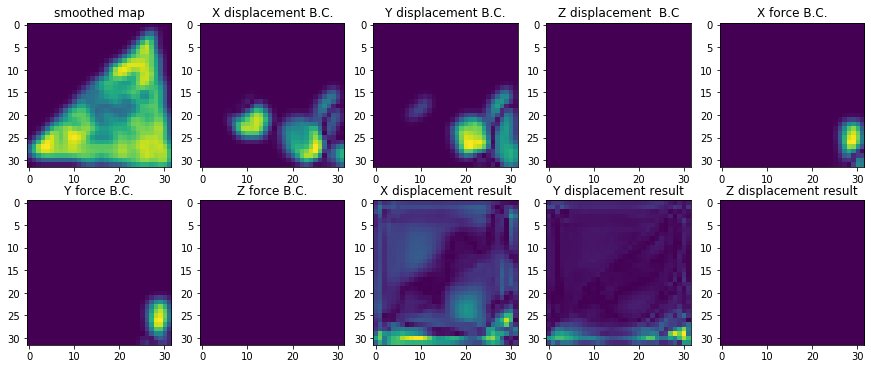

Sequential(
  (0): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): SelfAttention(
    (query_conv): Conv2d(64, 21, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(64, 21, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU(inplace=True)
  (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU(inplace=True)
  (15): Conv2d(256, 512

In [48]:
sample =96
sample_bc = np.moveaxis(dataset[0][sample,:,:,:].numpy(), 0, 2)
## plot one of the results after passing the convolutional network through it once
sample_prediction = net.cpu().forward(dataset[0][sample:sample+1,:,:,:])
print(sample_prediction.shape)
sample_prediction = F.pad(sample_prediction, (0,0,0,0,0,1)).detach().numpy()
print(sample_prediction.shape)
sample_prediction = np.moveaxis(sample_prediction, 1, 3)
print(sample_prediction.shape)


#print(sample_prediction.shape, dataset[0][27:28,:,10,22], sample_prediction[:,:,10,22])
plot_grid_2d(sample_bc, sample_prediction[0,:,:,:])
net.cuda()

# BASE WITH REPETITION
This model tries to do backpropagation after several passes of the network instead of just one


In [73]:
## define the neural network's general shape

class RepetitionNet(nn.Module):
    def __init__(self):
        super(RepetitionNet, self).__init__()
        
        ## convolutional layers
        self.conv1 = nn.Conv2d(in_channels = 7, out_channels = 14, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 14, out_channels = 16, kernel_size = 3, padding = 1)
        self.deconv1 = nn.ConvTranspose2d(in_channels = 16, out_channels = 14, kernel_size = 3, padding = 1)
        self.deconv2 = nn.ConvTranspose2d(in_channels = 14, out_channels = 10, kernel_size = 3, padding = 1)
        self.deconv3 = nn.ConvTranspose2d(in_channels = 10, out_channels = 7, kernel_size = 3, padding = 1)
        self.deconv4 = nn.ConvTranspose2d(in_channels = 7, out_channels = 3, kernel_size = 3, padding = 1)
        
        ## activation
        self.hardtanh = nn.Hardtanh()
        self.lrelu = nn.LeakyReLU(0.2)
        
        ##possible for later: MultiheadAttention
        self.multihead_attn_14 = SelfAttention(in_dim = 14, activation = None)
        
        
    def forward(self, boundary_conditions, returns):
        if not(returns): #if returns is false return the input
            #print(boundary_conditions.shape)
            x = self.conv1(boundary_conditions)
            x = self.multihead_attn_14(x)
            x = self.lrelu(x)
            #print(x.shape)
            x = self.conv2(x)
            #x, attn = self.multihead_attn_middle(x)
            x = self.lrelu(x)
            #print(x.shape)
            x = self.deconv1(x)
            x = self.lrelu(x)
           #print(x.shape)
            x = self.deconv2(x)
            x = self.lrelu(x)
            #print(x.shape)
            x = self.deconv3(x)
            x = self.lrelu(x)
        elif returns:
            x = self.conv1(boundary_conditions)
            x = self.multihead_attn_14(x)
            x = self.lrelu(x)
            #print(x.shape)
            x = self.conv2(x)
            #x, attn = self.multihead_attn_middle(x)
            x = self.lrelu(x)
            #print(x.shape)
            x = self.deconv1(x)
            x = self.lrelu(x)
           #print(x.shape)
            x = self.deconv2(x)
            x = self.lrelu(x)
            #print(x.shape)
            x = self.deconv3(x)
            x = self.lrelu(x)
            # print(x.shape)
            x = self.deconv4(x)  
            x = self.hardtanh(x)
            
        return x
    
net = RepetitionNet().cuda().float()

## test to see if getting the correct size
#%timeit net.forward(dataset[0][0:1,:,:,:].cuda(), returns = True)

In [72]:
## parameters
learn_rate = 0.0005
e = 3

In [74]:
## define criterion
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(params = net.parameters(), lr=learn_rate, betas=(0.9, 0.999))

In [75]:
## setup logging
wandb.init(config={"epochs": e, "batch_size": 90,'learning_rate': learn_rate, 'architecture':'repetition_attention_architecture'})

W&B Run: https://app.wandb.ai/walther/Project/runs/46mlsv2f

In [76]:
%%wandb

torch.autograd.set_detect_anomaly(True)
## define a general training loop
losses = np.array([0,0,0])
for epoch in range(e):  # loop over the dataset multiple times

    running_loss = 0.0
    boundary_conditions, targets = dataset[0][:90,:,:,:].cuda(), dataset[1][:90,:,:,:].cuda()
    #print(type(boundary_conditions))
    #net = net.cuda()
    for i, bc in enumerate(boundary_conditions):
        tgt = targets[i, 1:4, :, :].unsqueeze(0)
        bc = bc.unsqueeze(0)
        #material_matrix = boundary_conditions[i, 0, :, :].unsqueeze(0).repeat([1,3,1,1])
        #print(i, bc.shape, tgt.shape)

        # get the inputs; data is a list of [boundary_conditions, targets]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        repetitions = 3
        
        prediction = net(bc, returns = False)
        prediction = net(prediction, returns = False)
        prediction = net(prediction, returns = False)
       # prediction = net(prediction, returns = 'input')
        #rint(i)
        #for ii in range(repetitions):
            #print(ii)
            #prediction = net(prediction, returns = 'input')
        
        prediction =  net(prediction, returns = True)
        
        loss = criterion(prediction, tgt)#/torch.sum(material_matrix)
        #print(loss)
        loss.backward()
        optimizer.step()
        
        
        # print statistics
        running_loss += loss.item()
        wandb.log({"loss": loss})

        if i % 100 == 0:    # print every 10 mini-batches
            running_val_loss = 0.0
            with torch.no_grad():
                boundary_conditions_val, targets_val = dataset[0][90:,:,:,:].cuda(), dataset[1][90:,:,:,:].cuda()
                for ii, bc_val in enumerate(boundary_conditions_val):
                    tgt_val = targets_val[i, 1:4, :, :].unsqueeze(0)
                    bc_val = bc_val.unsqueeze(0)
                    prediction_val = net(bc_val, returns = 'output')
                    val_loss = criterion(prediction_val, tgt_val)#/torch.sum(material_matrix)
                    wandb.log({"val_loss": val_loss})
                    running_val_loss+=val_loss.item()
                
            print(f'{epoch + 1} {i + 1} {running_loss} {running_val_loss/10}')
            #wandb.log({"loss": running_loss})
            #wandb.log({"val_loss": running_val_loss})
            losses = np.vstack((losses, [epoch, running_loss, running_val_loss]))
            #print(losses)
            running_loss = 0.0
            

print('Finished Training')

1 1 0.019998053088784218 0.0218000927940011
2 1 0.0007985763950273395 0.0010863074916414917
3 1 0.0006409389898180962 0.0008965142245870083
Finished Training


torch.Size([1, 3, 32, 32])
(1, 4, 32, 32)
(1, 32, 32, 4)


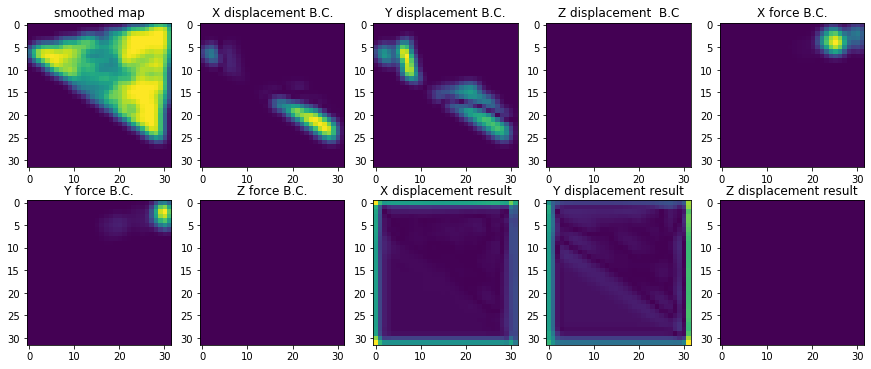

RepetitionNet(
  (conv1): Conv2d(7, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(14, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv1): ConvTranspose2d(16, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(14, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): ConvTranspose2d(10, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv4): ConvTranspose2d(7, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hardtanh): Hardtanh(min_val=-1.0, max_val=1.0)
  (lrelu): LeakyReLU(negative_slope=0.2)
  (multihead_attn_14): SelfAttention(
    (query_conv): Conv2d(14, 4, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(14, 4, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(14, 14, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
)

In [77]:
sample =3
sample_bc = np.moveaxis(dataset[0][sample,:,:,:].numpy(), 0, 2)
## plot one of the results after passing the convolutional network through it once
sample_prediction = net.cpu().forward(dataset[0][sample:sample+1,:,:,:], returns = 'output')
print(sample_prediction.shape)
sample_prediction = F.pad(sample_prediction, (0,0,0,0,0,1)).detach().numpy()
print(sample_prediction.shape)
sample_prediction = np.moveaxis(sample_prediction, 1, 3)
print(sample_prediction.shape)


#print(sample_prediction.shape, dataset[0][27:28,:,10,22], sample_prediction[:,:,10,22])
plot_grid_2d(sample_bc, sample_prediction[0,:,:,:])
net.cuda()

(32, 32, 7) (32, 32, 4)


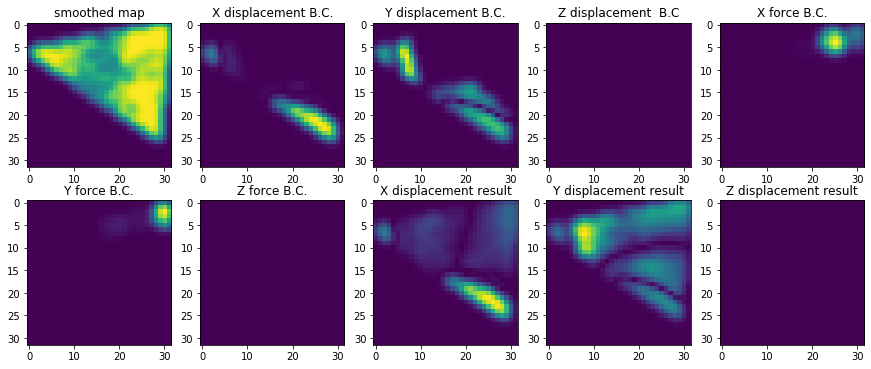

In [78]:
#plot ground truth11
sample_bc = np.moveaxis(dataset[0][sample,:,:,:].numpy(), 0, 2)
sample_target = np.moveaxis(dataset[1][sample,:,:,:].numpy(), 0, 2)
print(sample_bc.shape, sample_target.shape)
plot_grid_2d(sample_bc, sample_target)

The visual results for this network are very interesting for the first iteration. It takes a longer time to train, but it was able to create a map of where the feature is. Now attempting to see the result of running more than one iteration

In [79]:
prediction = net.cpu().forward(dataset[0][sample:sample+1,:,:,:], returns = False)
i = 0

In [295]:
with torch.no_grad():
    prediction = net(prediction, returns = False)
    i +=1
    print(i)

3


torch.Size([1, 3, 32, 32])
(1, 4, 32, 32)
(1, 32, 32, 4)


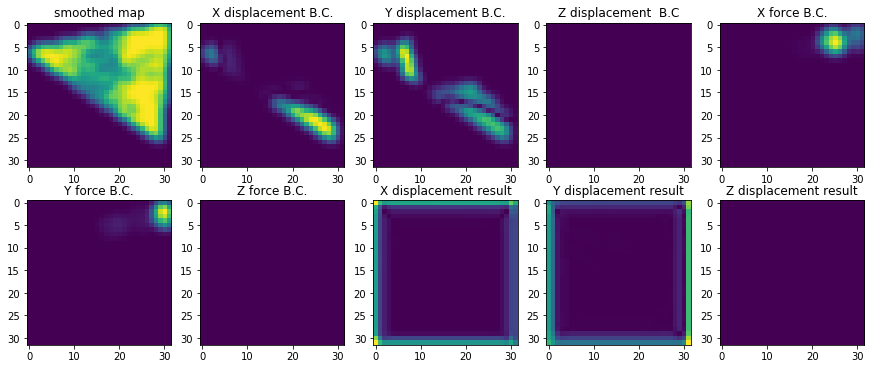

In [80]:
sample_prediction = net(prediction, returns = 'output')
print(sample_prediction.shape)
sample_prediction = F.pad(sample_prediction, (0,0,0,0,0,1)).detach().numpy()
print(sample_prediction.shape)
sample_prediction = np.moveaxis(sample_prediction, 1, 3)
print(sample_prediction.shape)


#print(sample_prediction.shape, dataset[0][27:28,:,10,22], sample_prediction[:,:,10,22])
plot_grid_2d(sample_bc, sample_prediction[0,:,:,:])

Doing this hasn't  helped with convergence it seems. Although letting it train led to the smallest loss yet, the problem seems to be that, again, the model is learning to fit the space around the element and not the element. A different strategy that requires a new dataset positioning and a dataloader to do data augmentation needs to be devised.